In [17]:
library(goseq)
library(Seurat)
library(stringr)

Loading required package: BiasedUrn
Loading required package: geneLenDataBase



In [32]:
1+1

[1] 2

In [16]:
geneinfo = read.table("/publicdata/gencode_v19_20151104/gene_info.tsv", sep = "\t", header = T)

In [3]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"

In [23]:
plot_go_barplots <- function(table, t){
    
    par(mar = c(8, 15, 2, 1))
    
    if(length(table[table$bh == 0, ]$bh) > 0){
        table[table$bh == 0, ]$bh = 10e-100
    }

    
    barplot(-log(table$bh[10:1], 10), names.arg=table$term[10:1], horiz=T, main=t,
            las=1, cex.axis=1, cex.names=1.1)
    abline(v=1.3, lwd=2, lty=2, col="red")
    
}

In [20]:
## GO enrichment
FindGOenrichment <- function(genes, all.genes){
    
    list1 = genes
    list2 = all.genes

    genes_data = data.frame(gene = list2, inlist = 0, stringsAsFactors = FALSE)
    genes_data[genes_data$gene %in% list1, "inlist"] = 1
    genes_data$gene_id = str_split_fixed(genes_data$gene, "\\.", 2)[,1]
    genes_data = genes_data[!duplicated(genes_data$gene_id),]
    rownames(genes_data) = genes_data$gene_id
    genes_data$gene_id = NULL

    genes = genes_data$inlist
    names(genes) = rownames(genes_data)
    pwf=nullp(genes,"hg19", "ensGene", plot.fit = FALSE)
    gowall=goseq(pwf,"hg19","ensGene")

    gowall = gowall[gowall$numInCat > 10 & gowall$numInCat < 1000,]
    
    gowall$list1      = length(genes_data[genes_data$inlist == 1, "inlist"])
    gowall$list2      = length(genes_data[genes_data$inlist == 0, "inlist"])
    gowall$pvalue     = apply(gowall[, c("over_represented_pvalue", "under_represented_pvalue")], 1, min)
    gowall$bonferroni = p.adjust(gowall$pvalue, method = "bonferroni")
    gowall$bh         = p.adjust(gowall$pvalue, method = "BH")
    gowall_ordered <- gowall[order(gowall$over_represented_pvalue),]
    
    return(gowall_ordered)
    
}

In [98]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.analyzed.filtered.clustered", sep = "")
load(f, verbose = T)

Loading objects:
  tiss.filtered


In [102]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.integrated.frazer.melton_cluster0_seurat_obj", sep = "")
load(f, verbose = T)

Loading objects:
  integrated.C0_test


In [8]:
bg = rownames(integrated.C0_test)
bg = geneinfo[geneinfo$gene_name %in% bg, "gene_id"]

# Visualize PPC data

In [3]:
integrated_meta = read.table(paste(out, "integrated_annotations.txt", sep = ""))

In [99]:
tiss.filtered@meta.data$major_cell_population = integrated_meta[match(rownames(tiss.filtered@meta.data), rownames(integrated_meta)), "major_cell_population"] 
tiss.filtered@meta.data$minor_cell_population = integrated_meta[match(rownames(tiss.filtered@meta.data), rownames(integrated_meta)), "minor_cell_population"] 

In [100]:
tiss.filtered@meta.data[tiss.filtered@meta.data$seurat_clusters == 2, ]$major_cell_population <- "iPSC"
tiss.filtered@meta.data[tiss.filtered@meta.data$seurat_clusters == 7, ]$major_cell_population <- "Endocrine"
tiss.filtered@meta.data[tiss.filtered@meta.data$seurat_clusters == 8, ]$major_cell_population <- "Endothelial"

In [103]:
c4_cells = rownames(integrated.C0_test@meta.data[integrated.C0_test@meta.data$RNA_snn_res.0.3 == "4" & integrated.C0_test@meta.data$study == "Frazer", ])
tiss.filtered@meta.data$major_cell_population_updated = tiss.filtered@meta.data$major_cell_population
tiss.filtered@meta.data[rownames(tiss.filtered@meta.data) %in% c4_cells , "major_cell_population_updated"] = "0_PPC_unknown"

In [104]:
cols = data.frame(celltype = sort(unique(tiss.filtered$major_cell_population)),
                  col = c("#56ccd8", "#9c0031", "#5ebd53", "#d984c6", "#ede99a", "#d49100", "#c9c230", "#a39000", "#827f80"))

cols[cols$celltype %in% c("PPC_early", "PPC_late", "PPC_moderate_1", "PPC_moderate_2"), "col"] = "#42d488"
cols[cols$celltype %in% c("iPSC"), "col"] = "#02592c"

colsInt = rbind(data.frame(celltype = "0_PPC_unknown", col = "#7dba9a"), cols)

In [207]:
colsInt

celltype,col
<chr>,<chr>
0_PPC_unknown,#7dba9a
Endocrine,#56ccd8
Endothelial,#9c0031
iPSC,#02592c
mesenchymal,#d984c6
PPC_early,#42d488
PPC_late,#42d488
PPC_moderate_1,#42d488
PPC_moderate_2,#42d488


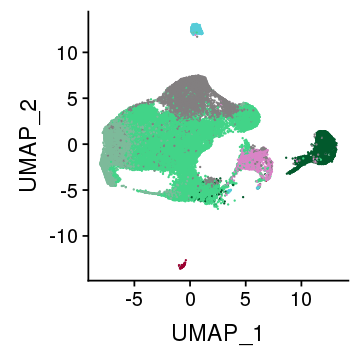

In [23]:
options(repr.plot.width = 3, repr.plot.height = 3)
DimPlot(tiss.filtered, reduction = "umap", group.by = "major_cell_population_updated", cols = colsInt$col, label = F) + NoLegend()

In [208]:
tiss.filtered

An object of class Seurat 
59820 features across 88188 samples within 2 assays 
Active assay: RNA (57820 features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

In [210]:
save(tiss.filtered, file = paste(out, "obj.analyzed.filtered.clustered_finalAnnotation", sep = ""))

In [209]:
write.table(tiss.filtered@meta.data, file = paste(out, "frazer_study_cells_annotations_191216.txt", sep = ""))

# T2D gene expression

In [90]:
t2dloci = read.table('/frazer01/projects/PPC/analysis/snATAC_analysis/t2d_loci/t2d_loci.bed', header = F)

In [94]:
t2d.genes = unique(str_split_fixed(t2dloci$V4, "_", 3)[, 1])

In [108]:
expression_matrix = tiss.filtered@assays$RNA
expression_matrix.t2d = expression_matrix[rownames(expression_matrix) %in% t2d.genes, ]
expression_matrix.t2d = as.matrix(expression_matrix.t2d)

In [120]:
tiss.filtered@meta.data$Barcode <- rownames(tiss.filtered@meta.data) 
ct.barcodes = data.frame(tiss.filtered@meta.data$major_cell_population, tiss.filtered@meta.data$Barcode)
colnames(ct.barcodes) <- c("cell", "barcode")

In [188]:
ct.barcodes[ct.barcodes$cell == "PPC_moderate_1", "cell"] = "PPC"
ct.barcodes[ct.barcodes$cell == "PPC_moderate_2", "cell"] = "PPC"
ct.barcodes[ct.barcodes$cell == "PPC_early", "cell"] = "PPC"
ct.barcodes[ct.barcodes$cell == "PPC_late", "cell"] = "PPC"
# unique(ct.barcodes$cell)

In [165]:
checkexpressed = data.frame(t2d_genes = rownames(expression_matrix.t2d), iPSC = NA, PPC = NA, repl = NA, mesenchymal = NA, Endocrine = NA, Endothelial = NA)

In [158]:
CheckIfExpressed <- function(row, celltype){

    this = expression_matrix.t2d[row, colnames(expression_matrix.t2d) %in% ct.barcodes[ct.barcodes$cell == celltype , "barcode"]]
    return(sum(this > 0) / length(this))
}

In [169]:
for(gene in seq(1, nrow(checkexpressed))){
    
    for(celltype in seq(2, ncol(checkexpressed))){

        checkexpressed[gene, celltype] = CheckIfExpressed(gene, colnames(checkexpressed)[celltype])   
    }
}

In [174]:
checkexpressed_in25 = checkexpressed

In [176]:
rownames(checkexpressed_in25) <- checkexpressed_in25$t2d_genes
checkexpressed_in25$t2d_genes <- NULL

In [180]:
checkexpressed_in25$n_celltypes_gt_25 = apply(checkexpressed_in25, 1, function(i) sum(i > .25))

In [184]:
checkexpressed_in25$n_celltypes_gt_10 = apply(checkexpressed_in25, 1, function(i) sum(i > .10))

In [181]:
head(checkexpressed_in25)

,iPSC,PPC,repl,mesenchymal,Endocrine,Endothelial,n_celltypes_gt_25
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
MACF1,0.365400544,0.518280119,0.614424635,0.35063031,0.46363636,0.71059432,6
FAF1,0.137616850,0.093053714,0.185170178,0.17326297,0.09292929,0.09043928,0
PTGFRN,0.042125192,0.158395758,0.246191248,0.17091762,0.10101010,0.17829457,0
NOTCH2,0.094426695,0.300643677,0.393030794,0.15215479,0.15353535,0.12661499,2
FAM63A,0.010294640,0.046958105,0.046515397,0.04573439,0.06565657,0.04134367,0
BNIPL,0.001656609,0.001421521,0.001620746,0.01114043,0.00000000,0.00000000,0


In [183]:
table(checkexpressed_in25$n_celltypes_gt_25)
nrow(checkexpressed_in25)


  0   1   2   3   4   5   6 
141  24  18  10   7  10  14 

[1] 224

In [187]:
write.table(checkexpressed_in25, file = "../Table/ppc_expressed_genes.txt", quote = F)

# Calculate DE for all clusters (iPSC, all PPCs, repl, endocrine, endothelial, mesenchymal)

In [24]:
tiss.filtered

An object of class Seurat 
59820 features across 88188 samples within 2 assays 
Active assay: RNA (57820 features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

In [25]:
Idents(tiss.filtered) <- "major_cell_population_updated"

In [26]:
unique(Idents(tiss.filtered))

[1] iPSC           PPC_moderate_1 repl           mesenchymal    PPC_moderate_2
 [6] PPC_early      PPC_late       0_PPC_unknown  Endocrine      Endothelial   
10 Levels: iPSC PPC_moderate_1 repl mesenchymal PPC_moderate_2 ... Endothelial

In [40]:
table(tiss.filtered@meta.data$major_cell_population_updated )
length(tiss.filtered@meta.data$major_cell_population_updated )


 0_PPC_unknown      Endocrine    Endothelial           iPSC    mesenchymal 
          9476            960            375           8449           3411 
     PPC_early       PPC_late PPC_moderate_1 PPC_moderate_2           repl 
         13809           8496          16864          14008          12340 

[1] 88188

In [41]:
table(tiss.filtered@meta.data$major_cell_population )
length(tiss.filtered@meta.data$major_cell_population )


     Endocrine    Endothelial           iPSC    mesenchymal      PPC_early 
           990            387           8451           3411          13840 
      PPC_late PPC_moderate_1 PPC_moderate_2           repl 
         17078          17038          14653          12340 

[1] 88188

In [ ]:
iPSC_markers <- FindMarkers(tiss.filtered, ident.1 = "iPSC", ident.2 = NULL, min.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(iPSC_markers, file = paste(out, "iPSC_markers.txt", sep = ""))

In [13]:
repl_markers <- FindMarkers(tiss.filtered, ident.1 = "repl", ident.2 = NULL, min.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(repl_markers, file = paste(out, "repl_markers.txt", sep = ""))

In [14]:
mesenchymal_markers <- FindMarkers(tiss.filtered, ident.1 = "mesenchymal", ident.2 = NULL, min.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(mesenchymal_markers, file = paste(out, "mesenchymal_markers.txt", sep = ""))

In [15]:
Endocrine_markers <- FindMarkers(tiss.filtered, ident.1 = "Endocrine", ident.2 = NULL, min.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(Endocrine_markers, file = paste(out, "Endocrine_markers.txt", sep = ""))

In [17]:
endothelial_markers <- FindMarkers(tiss.filtered, ident.1 = "Endothelial", ident.2 = NULL, min.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(endothelial_markers, file = paste(out, "endothelial_markers.txt", sep = ""))

In [27]:
ppc_markers <- FindMarkers(tiss.filtered, ident.1 = c("PPC_early", "PPC_moderate_1", "PPC_moderate_2", "PPC_late"),
                                   ident.2 = NULL, min.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(ppc_markers, file = paste(out, "all.ppc_markers.txt", sep = ""))

In [28]:
nonppc_markers <- FindMarkers(tiss.filtered, ident.1 = c("0_PPC_unknown"),
                                   ident.2 = NULL, min.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(ppc_markers, file = paste(out, "non.ppc.c4_markers.txt", sep = ""))

# GO analysis on DE genes

In [29]:
GoWrapper <- function(marker.df){
    
    marker.df.id = geneinfo[geneinfo$gene_name %in% rownames(marker.df), "gene_id"]
    gowall = FindGOenrichment(marker.df.id, bg)
    return(gowall)
    
}

In [30]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"

iPSC_markers = read.table(paste(out, "iPSC_markers.txt", sep = ""))

repl_markers = read.table(paste(out, "repl_markers.txt", sep = ""))

mesenchymal_markers = read.table(paste(out, "mesenchymal_markers.txt", sep = ""))

Endocrine_markers = read.table(paste(out, "Endocrine_markers.txt", sep = ""))

endothelial_markers = read.table(paste(out, "endothelial_markers.txt", sep = ""))

ppc_markers = read.table(paste(out, "all.ppc_markers.txt", sep = ""))

nonppc_markers = read.table(paste(out, "non.ppc.c4_markers.txt", sep = ""))

In [31]:
bg = rownames(tiss.filtered)
bg = geneinfo[geneinfo$gene_name %in% bg, "gene_id"]

In [32]:
gowall_ipsc           = suppressWarnings(GoWrapper(iPSC_markers))
gowall_repl           = suppressWarnings(GoWrapper(repl_markers))
gowall_mesenchyme     = suppressWarnings(GoWrapper(mesenchymal_markers))
gowall_endocrine      = suppressWarnings(GoWrapper(Endocrine_markers))
gowall_endothelial    = suppressWarnings(GoWrapper(endothelial_markers))
gowall_ppc            = suppressWarnings(GoWrapper(ppc_markers))
gowall_nonppc         = suppressWarnings(GoWrapper(nonppc_markers))

Loading hg19 length data...
Fetching GO annotations...
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, 

In [33]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"

write.table(gowall_ipsc,            file = paste(out, "gowall_ipsc.txt", sep = ""))
write.table(gowall_repl,            file = paste(out, "gowall_repl.txt", sep = ""))
write.table(gowall_mesenchyme,      file = paste(out, "gowall_mesenchyme.txt", sep = ""))
write.table(gowall_endocrine,       file = paste(out, "gowall_endocrine.txt", sep = ""))
write.table(gowall_endothelial,     file = paste(out, "gowall_endothelial.txt", sep = ""))
write.table(gowall_ppc,             file = paste(out, "gowall_ppc.txt", sep = ""))
write.table(gowall_nonppc,          file = paste(out, "gowall_nonppc.txt", sep = ""))

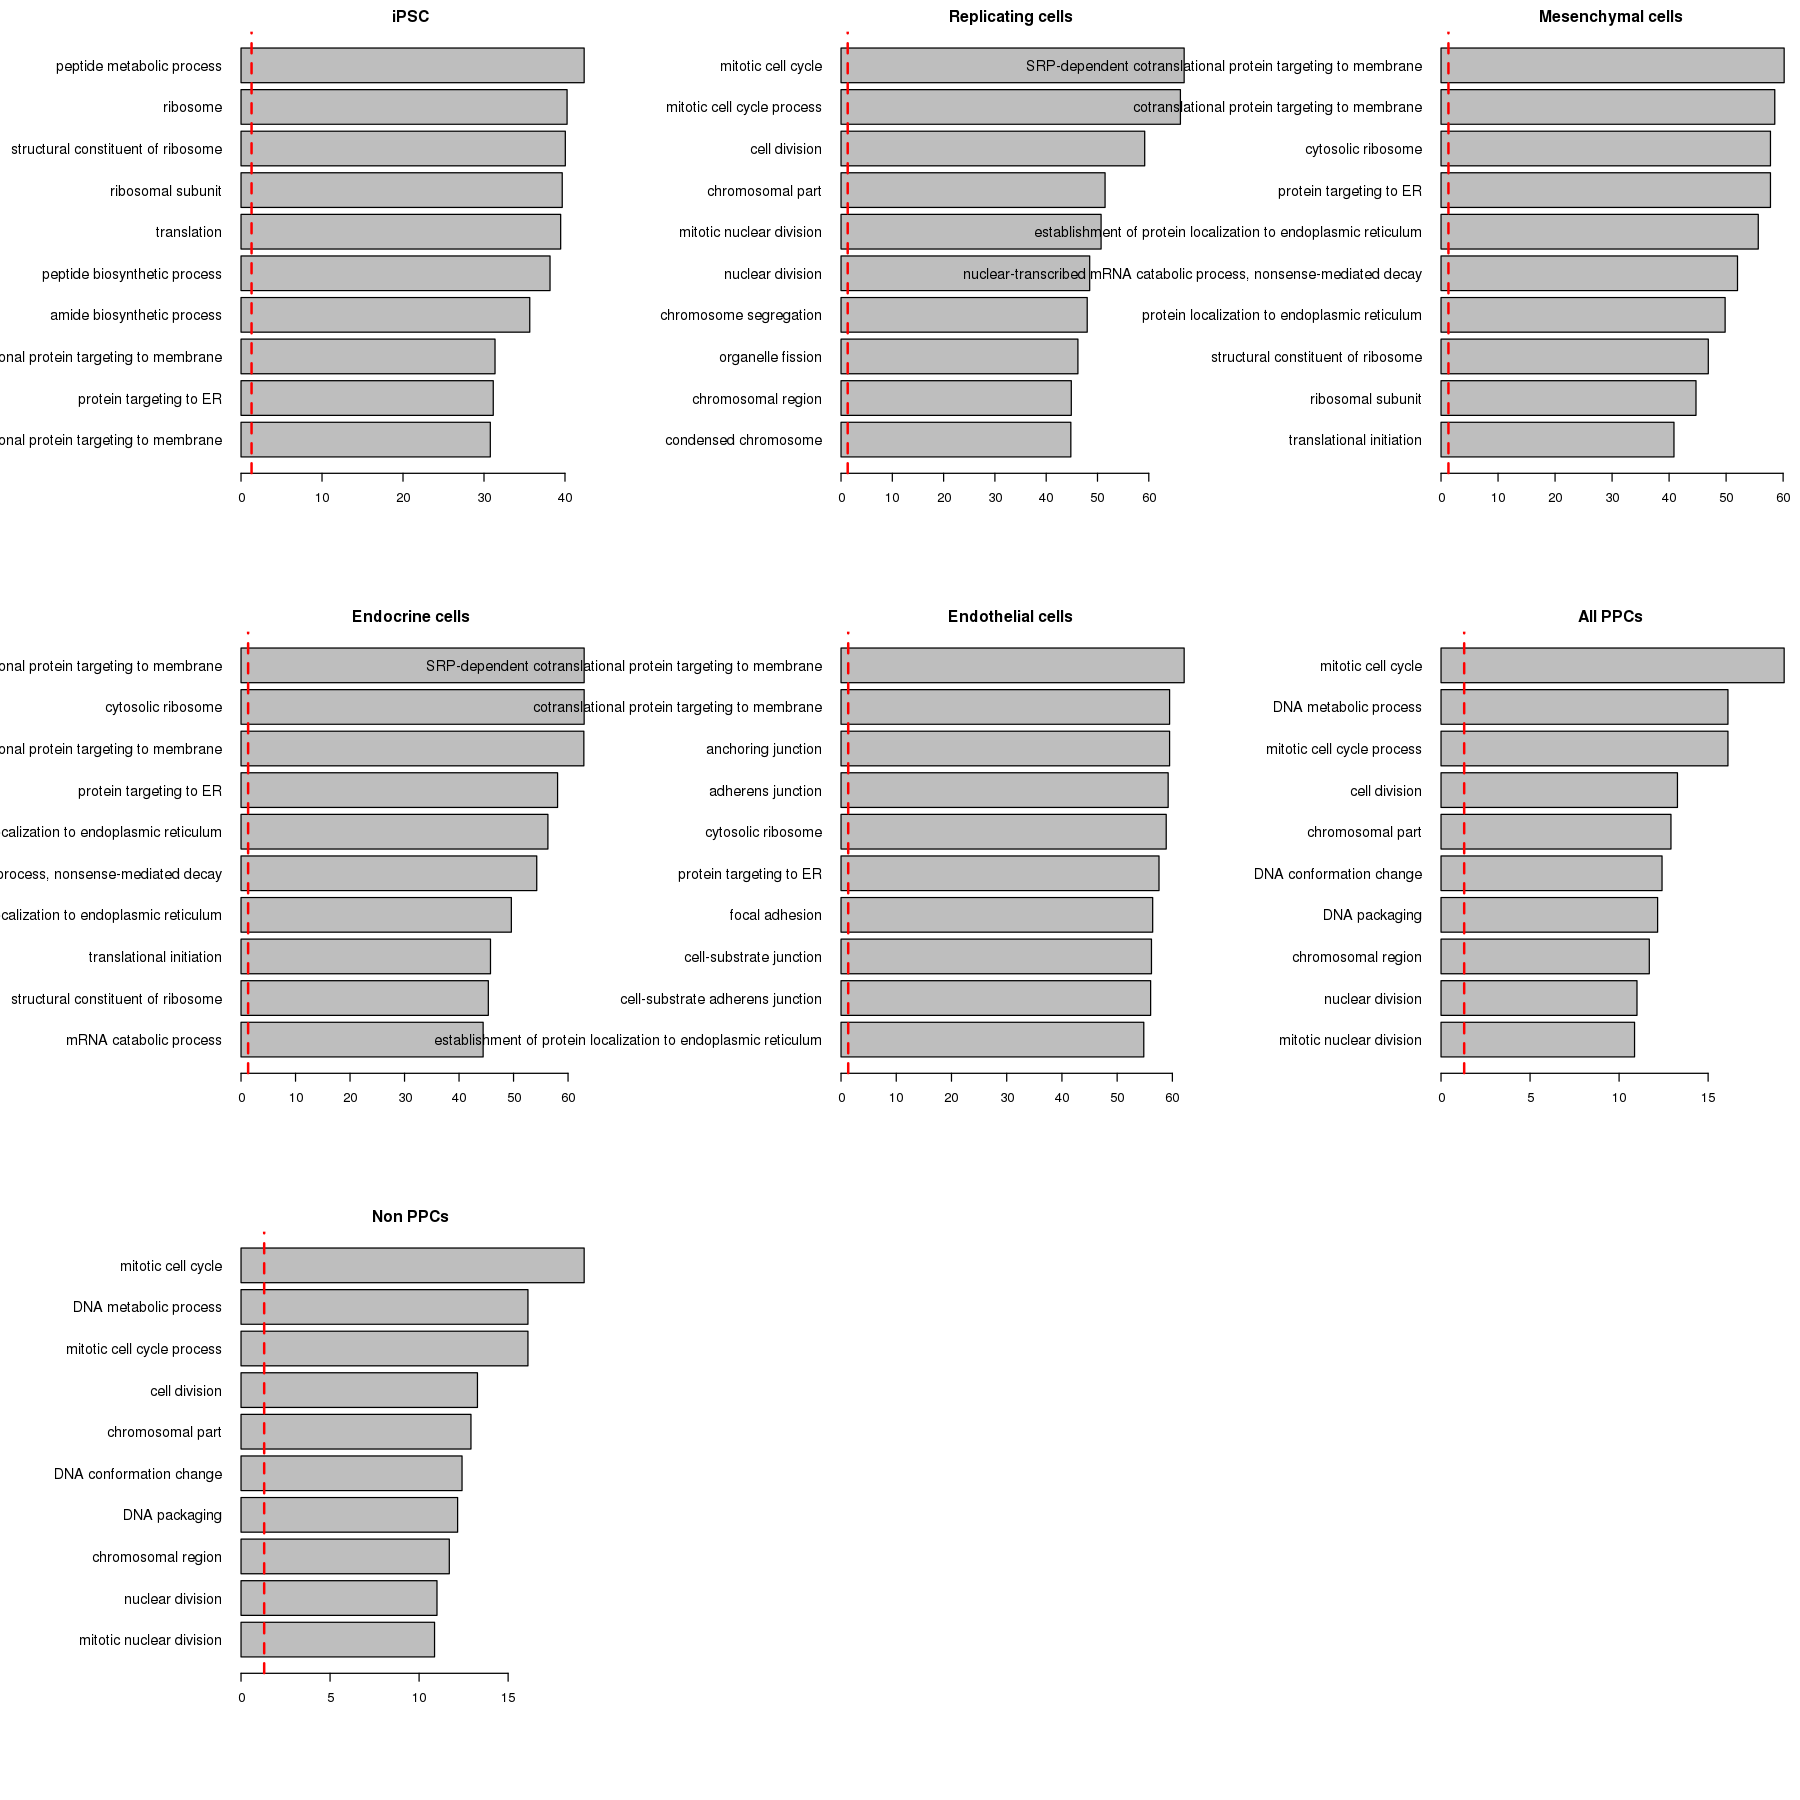

In [34]:
par(mfrow = c(3,3))
options(repr.plot.width = 15, repr.plot.height = 15)

plot_go_barplots(gowall_ipsc       , "iPSC")
plot_go_barplots(gowall_repl       , "Replicating cells")
plot_go_barplots(gowall_mesenchyme , "Mesenchymal cells")
plot_go_barplots(gowall_endocrine  , "Endocrine cells")
plot_go_barplots(gowall_endothelial, "Endothelial cells")
plot_go_barplots(gowall_ppc        , "All PPCs")
plot_go_barplots(gowall_nonppc     , "Non PPCs")

# Analyze ONLY Frazer PPCs

### Variable features in PPCs

In [35]:
tiss.filtered_ppc =  subset(tiss.filtered, idents = c("PPC_moderate_1", "PPC_moderate_2", "PPC_early", "PPC_late"))

In [36]:
tiss.filtered_ppc <- FindVariableFeatures(tiss.filtered_ppc, selection.method = "vst", nfeatures = 2000)

When using repel, set xnudge and ynudge to 0 for optimal results
Warning message:
“Transformation introduced infinite values in continuous x-axis”

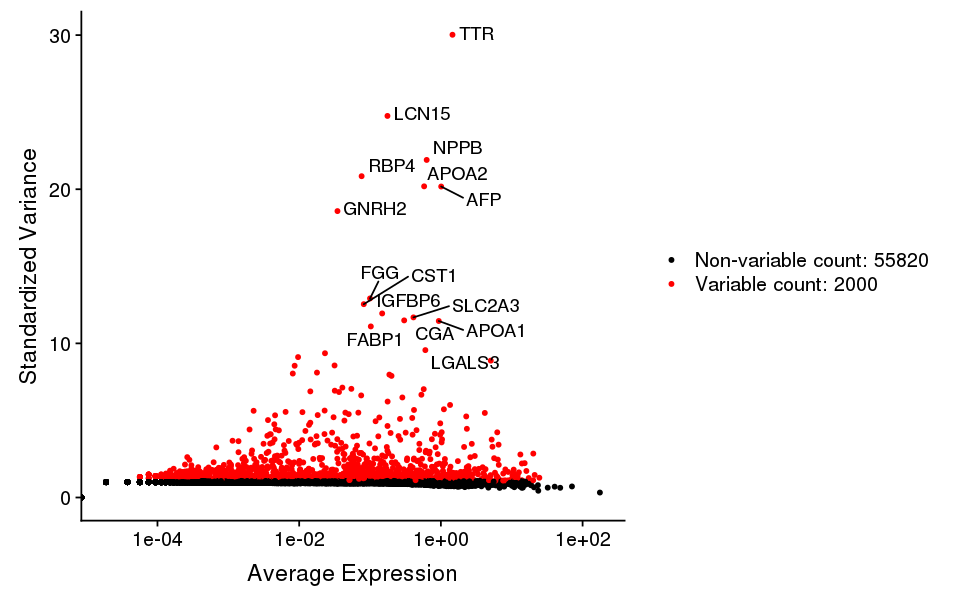

In [37]:
options(repr.plot.width = 8, repr.plot.height = 5)

top10 <- head(VariableFeatures(tiss.filtered_ppc), 15)
plot1 <- VariableFeaturePlot(tiss.filtered_ppc)
LabelPoints(plot = plot1, points = top10, repel = TRUE)

# How do these DE genes change over time? 

In [ ]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
load(paste(out, "obj.integrated.frazer.melton_cluster0_pseudotime", sep = ""), verbose = T)
cds

In [4]:
pData(cds)$pseudotime_bin = integrated_meta[match(rownames(pData(cds)), rownames(integrated_meta)), "major_cell_population"] 

In [5]:
# bin time by quantiles
pseudotime_ppc = as.data.frame(pseudotime(cds))
colnames(pseudotime_ppc) = "pseudotime"
quants = as.data.frame(quantile(pseudotime_ppc$pseudotime))

pseudotime_ppc$quants = NA
pseudotime_ppc$pseudotime = as.numeric(pseudotime_ppc$pseudotime)

pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[1, 1] & pseudotime_ppc$pseudotime <= quants[2, 1],  "quants" ] = "PPC_1"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[2, 1] & pseudotime_ppc$pseudotime <= quants[3, 1],  "quants" ] = "PPC_2"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[3, 1] & pseudotime_ppc$pseudotime <= quants[4, 1],  "quants" ] = "PPC_3"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[4, 1] & pseudotime_ppc$pseudotime <= quants[5, 1],  "quants" ] = "PPC_4"


pData(cds)$pseudotime_quantile = pseudotime_ppc[match(rownames(pData(cds)), rownames(pseudotime_ppc)), "quants"]

In [46]:
frazer_ppc_cells_no4   = rownames(pData(cds)[pData(cds)$study == "Frazer"  & (! pData(cds)$RNA_snn_res.0.3 %in% c("4")), ])

cds_subset <- cds[, frazer_ppc_cells_no4]

In [47]:
pData(cds_subset)$RNA_snn_res.0.3 <- as.numeric(pData(cds_subset)$RNA_snn_res.0.3)

## Bin pseudotime into 20 bins (for speed up) and calculate mean expression per bin

In [67]:
data = cds_subset@assays$data$counts
bins = as.data.frame(pseudotime(cds_subset))
bins$bin = cut(bins[,1], breaks = 4, labels = FALSE)

In [68]:
expressionBinned = data.frame(genes = rownames(data), bin_NA = NA)

for( pBin in unique(bins$bin)){
    
    cName = paste("bin", pBin, sep = "_")
    expressionBinned.temp = data.frame(genes = rownames(data),
                                       cName = rowMeans(as.matrix(data[, colnames(data) %in% rownames(bins[bins$bin == pBin, ])])))
    expressionBinned.temp = as.data.frame(expressionBinned.temp)
    colnames(expressionBinned.temp) <- c("genes", cName)
    
    expressionBinned = merge(expressionBinned, expressionBinned.temp, by="genes")
    
    
}

In [69]:
expressionBinned$bin_NA <- NULL

In [70]:
expressionBinned2model = as.data.frame(t(expressionBinned))
colnames(expressionBinned2model) <- expressionBinned2model[1,]
expressionBinned2model = expressionBinned2model[2:nrow(expressionBinned2model), ]

In [71]:
expressionBinned2model$pseudotime_bin = as.numeric(str_split_fixed(rownames(expressionBinned2model), "_", 2)[,2])

In [72]:
expressionBinned2model <- sapply( expressionBinned2model, as.numeric )
expressionBinned2model = expressionBinned2model[, colSums(expressionBinned2model != 0) > 0] # remove genes that have zero expression in all cells

In [73]:
expressionBinned2model = as.data.frame(expressionBinned2model)

In [74]:
dim(expressionBinned2model)

[1]     4 34038

## fit a lm

In [56]:
test = expressionBinned2model[, c(1:10, ncol(expressionBinned2model))]

In [57]:
CalculateGLM <- function(j, df){
    
    fit <- lm( as.numeric(df[,j]) ~ as.numeric(df[, ncol(df)])) #, data=df,family=quasipoisson())
    gene = colnames(df)[j]
    return(data.frame(gene_short_name = gene,
                      term            = "pseudotime_bin",
                      estimate        = coef(summary(fit))[2,1],
                      std_err         = coef(summary(fit))[2,2],
                      p_value         = coef(summary(fit))[2,4]))
        
}

In [58]:
fit_coefs = data.frame(gene_short_name = NA, term = NA, estimate = NA, std_err = NA, p_value = NA)

for(i in seq(1, (ncol(expressionBinned2model) - 1))){
    
    fit_coefs = rbind(fit_coefs, CalculateGLM(i, expressionBinned2model))
}
fit_coefs = fit_coefs[2:nrow(fit_coefs), ]
fit_coefs$q_value = p.adjust(fit_coefs$p_value)

In [59]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(fit_coefs, file = paste(out, "ppc_fit_coefs_frazer_ppc_allexpressedgenes_191212.txt", sep = ""))

# Analyze fit_coefs

In [239]:
# JAG1  https://www.ncbi.nlm.nih.gov/pubmed/19501159
# SPP1 (OPN) = marker of undifferentiated pancreatic precursors ; https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2562505/

In [61]:
fit_coefs_sig = fit_coefs[fit_coefs$q_value < 0.05, ]

In [62]:
head(fit_coefs_sig[order(-abs(fit_coefs_sig$estimate)), ], 3)

,gene_short_name,term,estimate,std_err,p_value,q_value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
32616,VIM,pseudotime_bin,0.09190821,0.008094978,1.223872e-09,4.163979e-05
4704,CALD1,pseudotime_bin,0.06585995,0.004749664,4.765476e-11,1.621882e-06
13080,KRT18,pseudotime_bin,0.05924715,0.006324982,2.418781e-08,8.216840e-04


In [64]:
head(fit_coefs_sig[order((fit_coefs_sig$estimate)), ], 3)

,gene_short_name,term,estimate,std_err,p_value,q_value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
10724,GPC3,pseudotime_bin,-0.04944246,0.006648596,6.824171e-07,0.023071841
32115,TXNIP,pseudotime_bin,-0.03479990,0.004436192,3.237218e-07,0.010962839
16437,ODC1,pseudotime_bin,-0.03378102,0.003692634,3.451181e-08,0.001172159


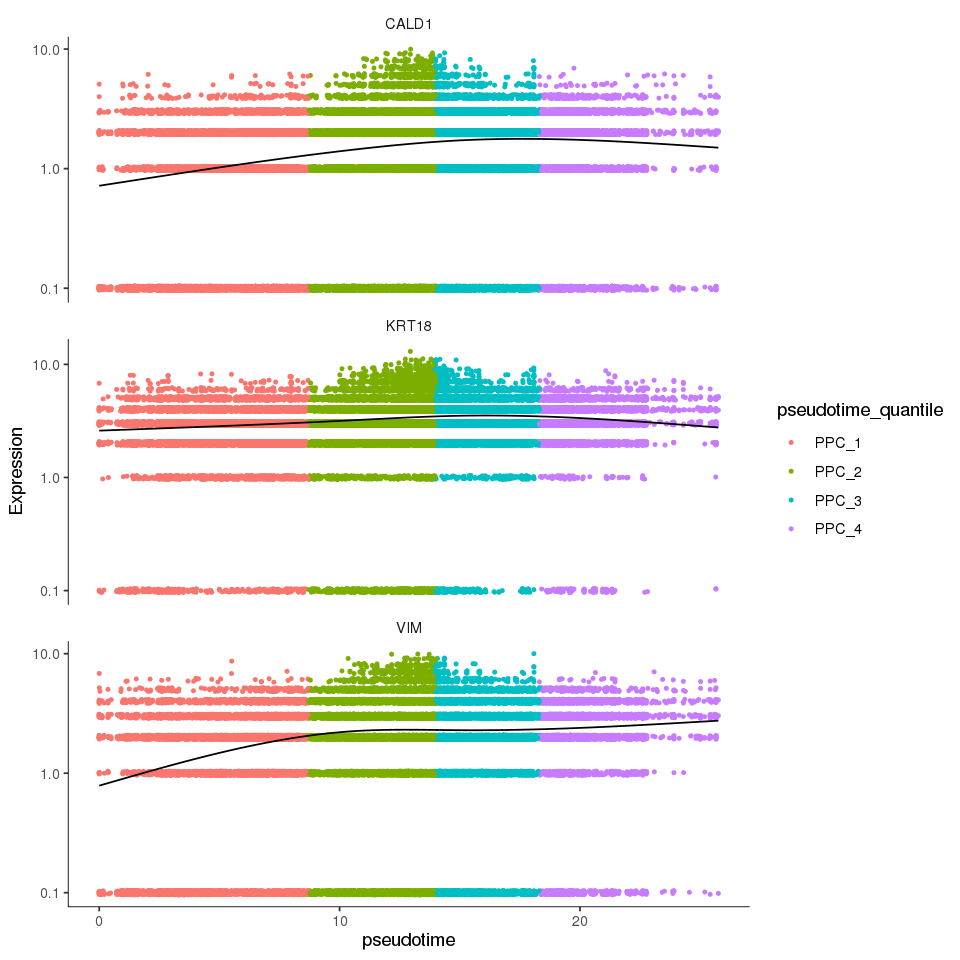

In [63]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot_genes_in_pseudotime(cds_subset[rowData(cds_subset)$gene_short_name %in%
                                    head(fit_coefs_sig[order(-abs(fit_coefs_sig$estimate)), ], 3)$gene_short_name,], 
                         color_cells_by="pseudotime_quantile",
                         min_expr=0.1)

# Mfuzz to find non-linear changes in gene expression

In [75]:
expressionBinned2model2mfuzz = expressionBinned2model

In [76]:
rownames(expressionBinned2model2mfuzz) <- paste("time", expressionBinned2model2mfuzz$pseudotime_bin, sep = "_")

In [77]:
expressionBinned2model2mfuzz = as.data.frame(t(expressionBinned2model2mfuzz[order(rownames(expressionBinned2model2mfuzz)), ]))

In [78]:
write.table(expressionBinned2model2mfuzz, "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/ppc_expression_binpseudo4_191213.txt")

In [2]:
load("/frazer01/home/jennifer/projects/PPCs/mfuzz/out/20191213_mfuzz_10clusters.robj", verbose = T)

Loading objects:
  mfuzzOut


In [3]:
head(as.data.frame(mfuzzOut$membership))

,1,2,3,4,5,6,7,8,9,10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5S-rRNA.4,0.07703239,0.32388777,0.08912930,0.04555290,0.04344746,0.05426953,0.13842809,0.14204087,0.04112437,0.04508731
7SK,0.31334426,0.10954437,0.06017328,0.04695313,0.06650078,0.04721998,0.10360878,0.07091562,0.05251830,0.12922149
7SK.2,0.05769311,0.17768176,0.20016013,0.04022152,0.03838781,0.06264494,0.05371554,0.27159038,0.03917142,0.05873341
7SK.3,0.02186714,0.06831526,0.31806897,0.02025666,0.01698509,0.03683497,0.02358571,0.45444735,0.01834471,0.02129413
7SK.4,0.18283751,0.06811145,0.04897593,0.08528953,0.16984816,0.05565106,0.15810682,0.05373924,0.09620002,0.08124027
A1BG,0.09087540,0.08664877,0.04790600,0.05091555,0.05420942,0.04430761,0.47879604,0.05913915,0.04602497,0.04117708


In [4]:
memb = as.data.frame(mfuzzOut$membership)

In [5]:
memb$maxCol = colnames(memb)[apply(memb,1,which.max)]

In [6]:
memb$real = NA
for( i in seq(1, nrow(memb))){
    memb[i, "real"] = memb[i, memb[i, "maxCol"]] > 0.50   
}

In [7]:
table(memb$real, memb$maxCol)

       
           1   10    2    3    4    5    6    7    8    9
  FALSE 1858 1447 2571 2765 2483 2744 2616 1745 2267 2266
  TRUE   611 1819  473 1858  959  980  613 1814  945 1204

In [86]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(memb, file = paste(out, "mfuzz_k10_b4_memberships_191213.txt", sep = ""))

In [8]:
memb.real = memb[memb$real == TRUE,]

In [9]:
x = as.data.frame(table(memb.real$maxCol))
x = x[c(1, 3:10, 2),]
# x$Var1 = paste("cluster", x$Var1, sep = "_")

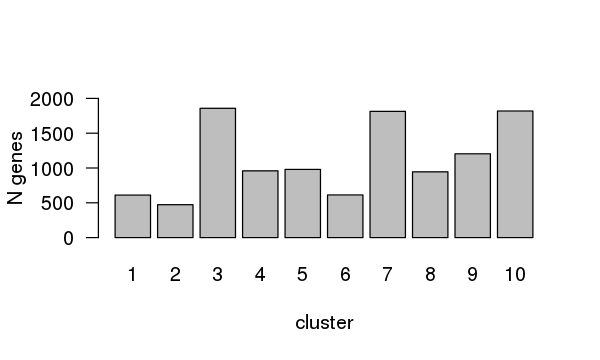

In [10]:
options(repr.plot.width = 5, repr.plot.height = 3)
barplot(x$Freq,las = 1, ylim = c(0, 2000), names.arg = x$Var1, xlab = "cluster", ylab = "N genes")

# T2D genes that change expression over time

In [11]:
nonlinear = rownames(memb.real[memb.real$maxCol %in% c(1, 6), ])

In [12]:
linear = fit_coefs_sig$gene_short_name

ERROR: Error in eval(expr, envir, enclos): object 'fit_coefs_sig' not found


In [13]:
delta_t2dgenes = t2d.genes[t2d.genes %in% c(linear, nonlinear)]

ERROR: Error in eval(expr, envir, enclos): object 't2d.genes' not found


In [205]:
delta_t2dgenes

length(t2d.genes)

[1] "MACF1"   "SEC16B"  "IRS2"    "RALY"    "HNF4A"   "YWHAH"   "ROBO2"  
 [8] "EGFEM1P" "CENPW"   "JAZF1"   "CPQ"     "UBAP2"

[1] 239

In [202]:
memb.real[memb.real$maxCol %in% c(1, 6) & rownames(memb.real) %in% delta_t2dgenes, ]

,1,2,3,4,5,6,7,8,9,10,maxCol,real
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
CENPW,0.02098732,0.02870447,0.05449963,0.05934169,0.02882018,0.67857642,0.02248124,0.04095889,0.04168518,0.02394498,6,TRUE
HNF4A,0.02315194,0.03113840,0.05700945,0.06940313,0.03242317,0.64459189,0.02490634,0.04366816,0.04746872,0.02623880,6,TRUE
RALY,0.02796453,0.04097123,0.08786715,0.06645960,0.03572920,0.56768269,0.03004827,0.06223966,0.04929504,0.03174262,6,TRUE
ROBO2,0.56766629,0.05001300,0.02964683,0.03362611,0.05565573,0.02786179,0.10760707,0.03425301,0.03769393,0.05597624,1,TRUE
SEC16B,0.69491669,0.04064875,0.02223863,0.02210920,0.03391932,0.01956536,0.07553170,0.02625472,0.02441333,0.04040231,1,TRUE
UBAP2,0.01775346,0.02354763,0.04574140,0.04849238,0.02484033,0.72964991,0.01816204,0.03347466,0.03664570,0.02169250,6,TRUE
YWHAH,0.01543088,0.02077153,0.04042265,0.04237119,0.02137253,0.76423482,0.01603843,0.02969863,0.03125642,0.01840290,6,TRUE


In [203]:
fit_coefs_sig[fit_coefs_sig$gene_short_name %in% delta_t2dgenes, ]

,gene_short_name,term,estimate,std_err,p_value,q_value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
6138,CPQ,pseudotime_bin,0.002911535,0.0003455525,1.162074e-07,3.941524e-03
8689,EGFEM1P,pseudotime_bin,-0.002854856,0.0003122342,3.478966e-08,1.181561e-03
12383,IRS2,pseudotime_bin,0.006306440,0.0004675811,7.526536e-11,2.561506e-06
12502,JAZF1,pseudotime_bin,0.004663075,0.0004669604,9.125293e-09,3.102143e-04
14228,MACF1,pseudotime_bin,0.024740852,0.0023688068,4.554969e-09,1.549008e-04


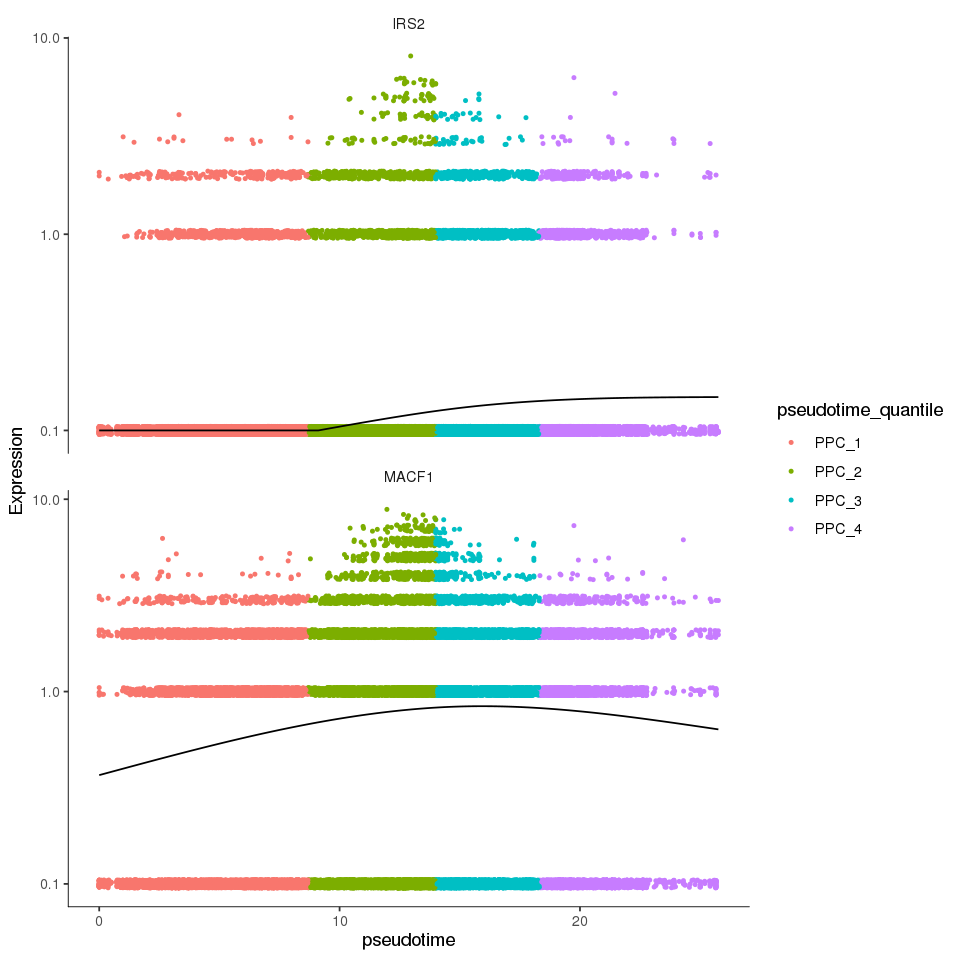

In [206]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot_genes_in_pseudotime(cds_subset[rowData(cds_subset)$gene_short_name %in% c("MACF1", "IRS2"),], 
                         color_cells_by="pseudotime_quantile",
                         min_expr=0.1)

# MFuzz GO

In [14]:
GoWrapperMfuzz <- function(cluster){
    
    bg = geneinfo[geneinfo$gene_name %in% rownames(memb), "gene_id"]
    memb.real_sub = memb.real[ memb.real$maxCol == cluster, ]
    marker.df.id = geneinfo[geneinfo$gene_name %in% rownames(memb.real_sub), "gene_id"]
    gowall = FindGOenrichment(marker.df.id, bg)
    return(gowall)
    
}

In [31]:
memb.real_sub = memb.real[ memb.real$maxCol == 6, ]
marker.df.id = geneinfo[geneinfo$gene_name %in% rownames(memb.real_sub), "gene_name"]

table(marker.df.id %in% "BPTF")


FALSE 
  612 

In [21]:
gowall2 = GoWrapperMfuzz(1)
gowall6 = GoWrapperMfuzz(6)

Loading hg19 length data...
Fetching GO annotations...
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, 

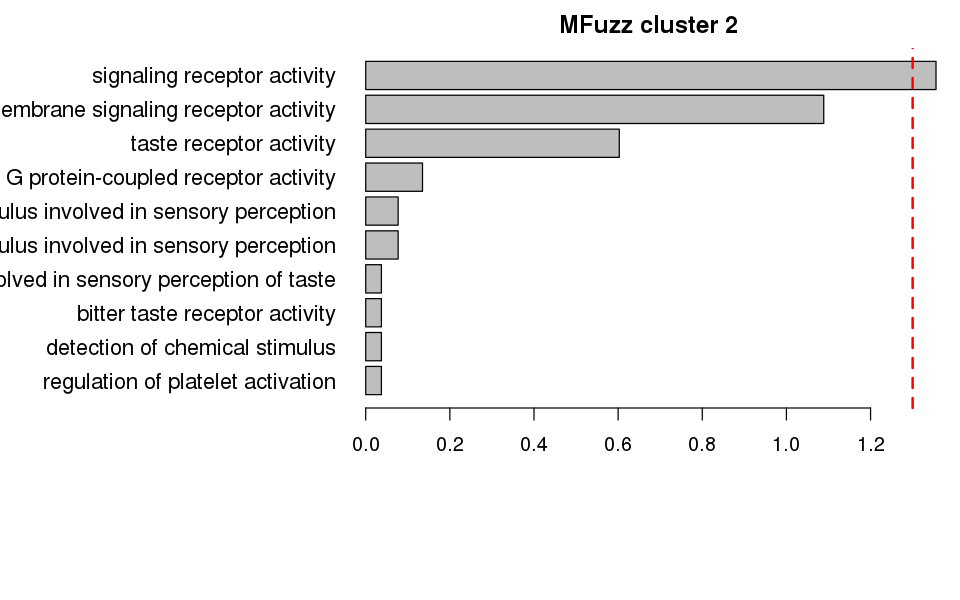

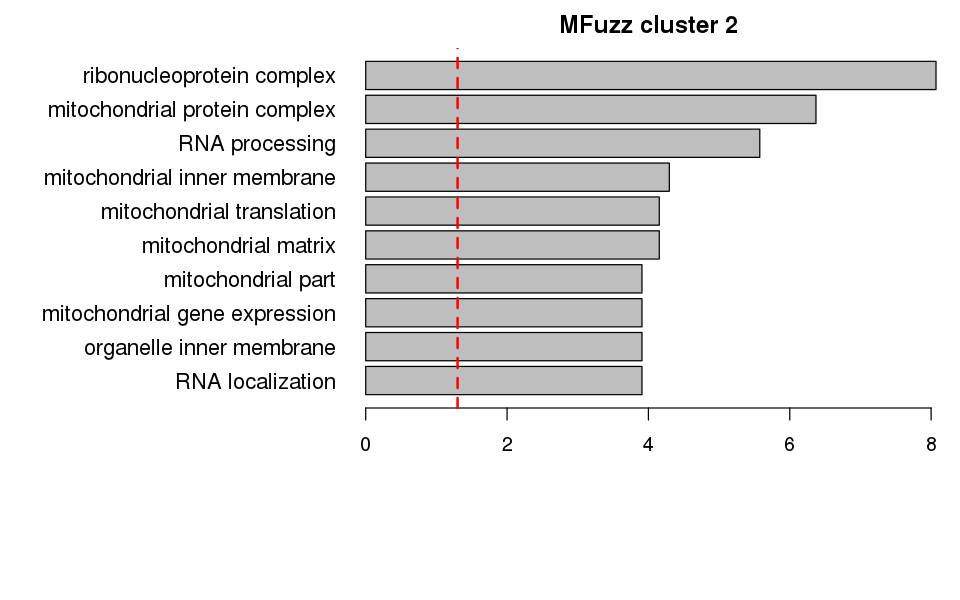

In [24]:
options(repr.plot.width = 8, repr.plot.height = 5)
plot_go_barplots(gowall2, "MFuzz cluster 2")
plot_go_barplots(gowall6, "MFuzz cluster 2")

In [25]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(gowall2, file = paste(out, "gowall_ppc_mid.up_191216.txt", sep = ""))
write.table(gowall6, file = paste(out, "gowall_ppc_mid.down_191216.txt", sep = ""))

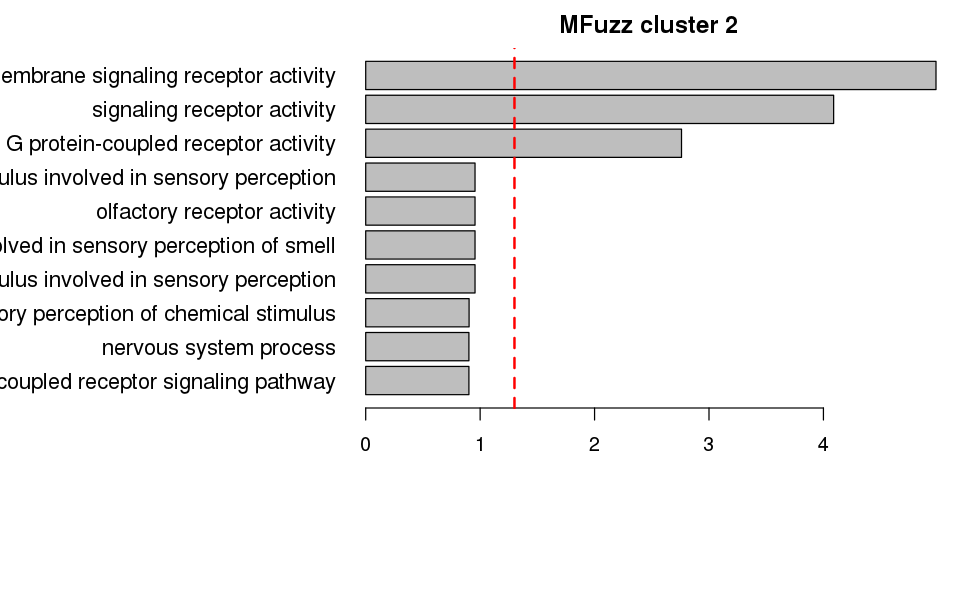

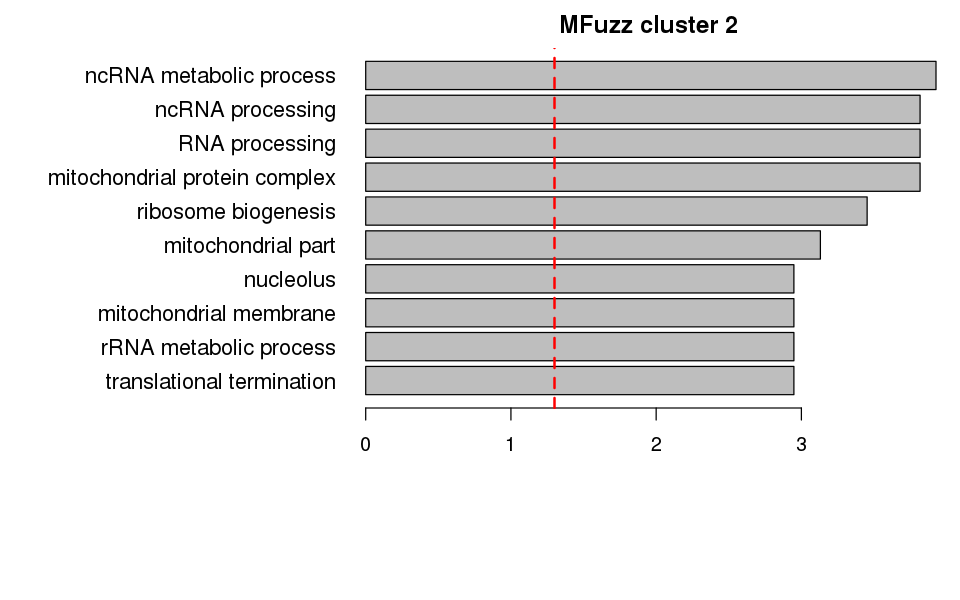

In [96]:
options(repr.plot.width = 8, repr.plot.height = 5)
plot_go_barplots(gowall2, "MFuzz cluster 2")
plot_go_barplots(gowall6, "MFuzz cluster 2")

# GSEA

In [289]:
suppressPackageStartupMessages(library(gage))

In [288]:
fit_coefs2gsea = fit_coefs[order(-(fit_coefs$estimate)), ]

In [291]:
read_gene_set_collection <- function (gene_set_collection = available_gene_sets()[[1]], gene_sets_folder = "/publicdata/MSigDB_20171129") 
{
    gene_set_file = paste(gene_sets_folder, "/", gene_set_collection, sep = "")
    dat = readLines(gene_set_file, warn = FALSE)
    dat = strsplit(dat, "\t")
    names(dat) = unlist(lapply(dat, function(x) {
        x[[1]]
    }))
    gene_set_names = rapply(dat, function(x) head(x, 1))
    gene_set_descriptions = rapply(dat, function(x) head(x, 2))[c(FALSE, 
        TRUE)]
    dat = lapply(dat, function(x) {
        x[-(1:2)]
    })
    return(list(gene_set_names, gene_set_descriptions, dat))
}
                                   
runGsea = function(exprs, gsets, set.size = c(0, 10000))
{
    gsea = gage(exprs = exprs, gsets = gsets,  set.size = set.size)
    
    greater    = as.data.frame(gsea$greater, stringsAsFactors = FALSE)
    less       = as.data.frame(gsea$less   , stringsAsFactors = FALSE)

    greater$id = rownames(greater)
    less$id    = rownames(less   )

    greater$pval_greater = greater$p.val
    greater$qval_greater = greater$q.val # BH correction
    less$pval_less       = less$p.val
    less$qval_less       = less$q.val    # BH correction

    out = merge(greater[, c("id", "stat.mean", "pval_greater", "qval_greater")], less[, c("id", "pval_less", "qval_less")])
    out = out[order(out$stat.mean, decreasing = TRUE),]
    
    out$pval = apply(out[,c("pval_greater", "pval_less")], 1, min)
    out$qval = apply(out[,c("qval_greater", "qval_less")], 1, min)
    
   return(out[,c("id", "stat.mean", "pval", "qval")])
}

In [359]:
# MSigDB 
gene_sets = c('c1.all.v6.1.symbols.gmt', 'c2.cp.biocarta.v6.1.symbols.gmt', 'c2.cp.kegg.v6.1.symbols.gmt',
              'c2.cp.reactome.v6.1.symbols.gmt', 'c3.mir.v6.1.symbols.gmt', 'c3.tft.v6.1.symbols.gmt',
              'c5.bp.v6.1.symbols.gmt', 'c5.cc.v6.1.symbols.gmt', 'c5.mf.v6.1.symbols.gmt',
              'h.all.v6.1.symbols.gmt', 'IPA_regulators.symbols.gmt', 
              'mitochondrial_genes.symbols.gmt')

In [360]:
gsea_msigdb_targeted = list()
counter = 1

for (file in gene_sets){

    gene_set_data = read_gene_set_collection(file,
                                             gene_sets_folder = "/publicdata/MSigDB_20171129")

    to_gsea   = fit_coefs2gsea[, c("gene_short_name", "estimate")]
    to_gsea <- aggregate(estimate ~ gene_short_name, data = to_gsea, FUN = mean)
    rownames(to_gsea) <- to_gsea$gene_short_name
    to_gsea$gene_short_name <- NULL
    to_gsea$value <- as.numeric(to_gsea$estimate)
    to_gsea$estimate <- NULL

    x = "" 
    for (i in gene_set_data[[1]]){
        x <- runGsea(exprs = to_gsea, gsets = gene_set_data[[3]])

    }
    gsea_msigdb_targeted[[counter]] <- x
    counter = counter + 1
}


In [361]:
all = data.frame(id = 1, stat.mean = 1, pval = 1, qval = 1)

for( i in seq(1, length(gsea_msigdb_targeted))){
    
    all = rbind(all, gsea_msigdb_targeted[[i]])

}

In [362]:
all = all[2:nrow(all),]

In [387]:
plot_go_barplots <- function(table, t){

    table$logq = -log(table$qval, 10)
    table[ table$stat.mean < 0, ]$logq = table[ table$stat.mean < 0, ]$logq*-1
    
    barplot(table$logq, names.arg=table$id, horiz=T, main=t,
            las=1, cex.axis=1, cex.names=0.5)
    abline(v=1.3, lwd=2, lty=2, col="red")
    abline(v=-1.3, lwd=2, lty=2, col="red")
    
}

In [388]:
all = all[order(all$qval), ]

In [ ]:
library(enrichplot)

In [ ]:
barplot(edo, showCategory=20)

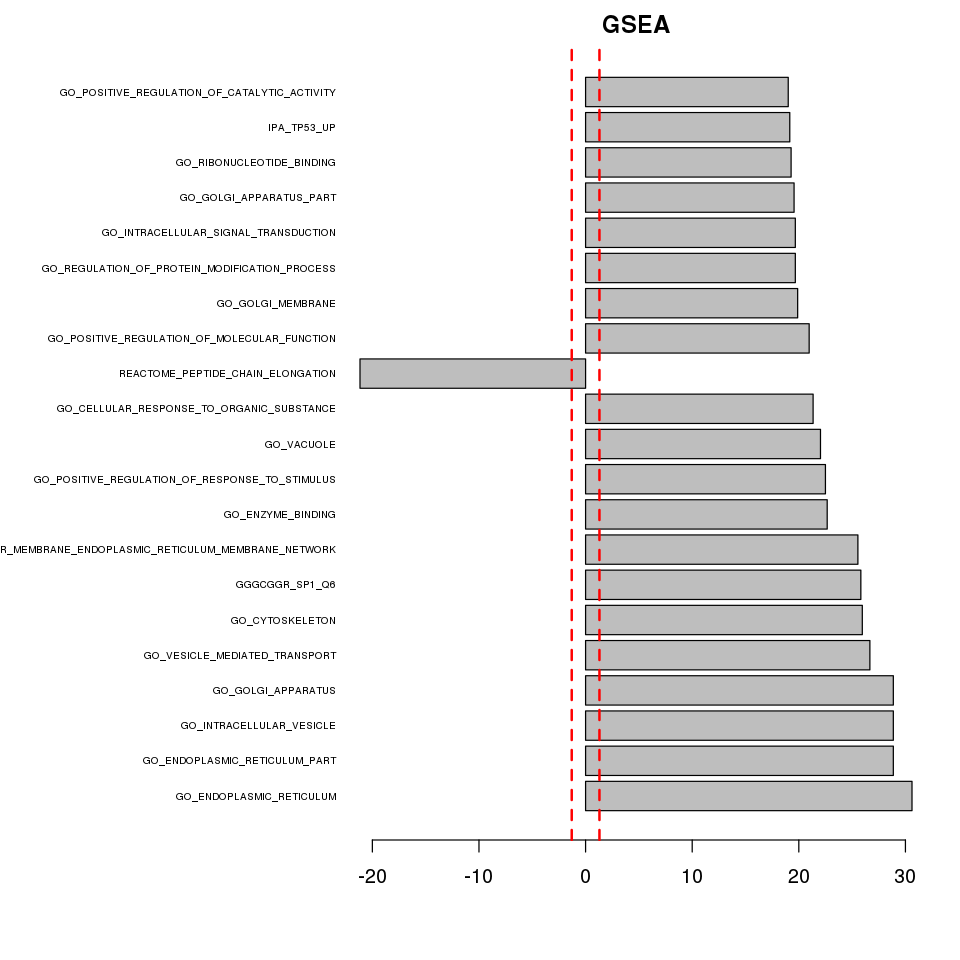

In [392]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mar = c(5, 15, 2, 2))
a = subset(all, qval < 10e-20)
plot_go_barplots(a[order(a$qval),], "GSEA")

In [365]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(all, file = paste(out, "ppc_fit_coefs_frazer_ppc_allexpressedgenes_gsea.txt", sep = ""))